<a href="https://colab.research.google.com/github/ashishmission93/ML-PTOJECTS/blob/main/fraud_analytics_assignment_2_Fraud_Detection_Using_an_Autoencoder_and_Variational_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1- Fraud Detection Using an Autoencoder and Variational Autoencoder

ASHISH KUMAR EM23MTECH14005

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import gdown

# Function to download the dataset from Google Drive
def load_data(url, file_name):
    gdown.download(url, file_name, quiet=False)
    data = pd.read_csv(file_name)
    return data

# Preprocessing the data
def preprocess_data(data):
    data['Time'] = np.log(data['Time'] + 1)
    data['Amount'] = np.log(data['Amount'] + 1)
    scaler = MinMaxScaler()
    X = scaler.fit_transform(data.drop('Class', axis=1))
    y = data['Class']
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Building a simple autoencoder
def build_autoencoder(input_dim, encoding_dim=14):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

# Variational Autoencoder
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def build_vae(input_dim, encoding_dim=14):
    input_layer = Input(shape=(input_dim,))
    z_mean = Dense(encoding_dim)(input_layer)
    z_log_var = Dense(encoding_dim)(input_layer)
    z = Lambda(sampling, output_shape=(encoding_dim,))([z_mean, z_log_var])
    decoded = Dense(input_dim, activation='sigmoid')(z)

    encoder = Model(input_layer, [z_mean, z_log_var, z])
    vae = Model(input_layer, decoded)

    reconstruction_loss = binary_crossentropy(input_layer, decoded)
    reconstruction_loss *= input_dim
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    return vae

# Main function to run the setup
def main():
    url = 'https://drive.google.com/uc?id=1mbioRY0d144mVqZPkYwYeJEgfS-8An1r'
    file_name = 'creditcard.csv'
    data = load_data(url, file_name)
    X_train, X_test, y_train, y_test = preprocess_data(data)

    print("Training Autoencoder")
    autoencoder = build_autoencoder(X_train.shape[1])
    autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, validation_data=(X_test, X_test))

    print("Training Variational Autoencoder")
    vae = build_vae(X_train.shape[1])
    vae.fit(X_train, epochs=50, batch_size=256, validation_data=(X_test, None))

    # Further code to evaluate the model could be added here

if __name__ == "__main__":
    main()


Downloading...
From (original): https://drive.google.com/uc?id=1mbioRY0d144mVqZPkYwYeJEgfS-8An1r
From (redirected): https://drive.google.com/uc?id=1mbioRY0d144mVqZPkYwYeJEgfS-8An1r&confirm=t&uuid=e14e1f68-a49a-4444-b2d6-97973da23a20
To: /content/creditcard.csv
100%|██████████| 151M/151M [00:01<00:00, 109MB/s] 


Training Autoencoder
Epoch 1/50
891/891 [==============================] - 6s 5ms/step - loss: 0.0056 - val_loss: 0.0018
Epoch 2/50
891/891 [==============================] - 2s 2ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 3/50
891/891 [==============================] - 2s 2ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 4/50
891/891 [==============================] - 2s 2ms/step - loss: 9.6745e-04 - val_loss: 8.8106e-04
Epoch 5/50
891/891 [==============================] - 2s 2ms/step - loss: 8.2855e-04 - val_loss: 7.8427e-04
Epoch 6/50
891/891 [==============================] - 3s 3ms/step - loss: 7.4365e-04 - val_loss: 7.0629e-04
Epoch 7/50
891/891 [==============================] - 2s 3ms/step - loss: 6.7264e-04 - val_loss: 6.4135e-04
Epoch 8/50
891/891 [==============================] - 2s 2ms/step - loss: 6.2053e-04 - val_loss: 6.0254e-04
Epoch 9/50
891/891 [==============================] - 2s 2ms/step - loss: 5.7783e-04 - val_loss: 5.3523e-04
Epoch 10/50
891/891 [==========

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, f1_score, precision_score, recall_score

# Function to compute reconstruction error and identify anomalies
def get_reconstruction_error(model, X_test):
    predictions = model.predict(X_test)
    mse = np.mean(np.power(X_test - predictions, 2), axis=1)
    return mse

# Function to classify transactions based on threshold and compute scores
def evaluate_model(y_true, error, threshold):
    y_pred = error > threshold
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return precision, recall, f1

# Main function to run the setup
def main():
    url = 'https://drive.google.com/uc?id=1mbioRY0d144mVqZPkYwYeJEgfS-8An1r'
    file_name = 'creditcard.csv'
    data = load_data(url, file_name)
    X_train, X_test, y_train, y_test = preprocess_data(data)

    print("Training Autoencoder")
    autoencoder = build_autoencoder(X_train.shape[1])
    autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, validation_data=(X_test, X_test))

    print("Evaluating Autoencoder")
    autoencoder_mse = get_reconstruction_error(autoencoder, X_test)
    threshold = np.quantile(autoencoder_mse, 0.95)  # Set threshold at 95th percentile
    ae_precision, ae_recall, ae_f1 = evaluate_model(y_test, autoencoder_mse, threshold)
    print("Autoencoder Precision:", ae_precision)
    print("Autoencoder Recall:", ae_recall)
    print("Autoencoder F1 Score:", ae_f1)

    print("Training Variational Autoencoder")
    vae = build_vae(X_train.shape[1])
    vae.fit(X_train, epochs=50, batch_size=256, validation_data=(X_test, None))

    print("Evaluating Variational Autoencoder")
    vae_mse = get_reconstruction_error(vae, X_test)
    threshold_vae = np.quantile(vae_mse, 0.95)  # Set threshold at 95th percentile
    vae_precision, vae_recall, vae_f1 = evaluate_model(y_test, vae_mse, threshold_vae)
    print("VAE Precision:", vae_precision)
    print("VAE Recall:", vae_recall)
    print("VAE F1 Score:", vae_f1)

if __name__ == "__main__":
    main()


Downloading...
From (original): https://drive.google.com/uc?id=1mbioRY0d144mVqZPkYwYeJEgfS-8An1r
From (redirected): https://drive.google.com/uc?id=1mbioRY0d144mVqZPkYwYeJEgfS-8An1r&confirm=t&uuid=6f9cd2a5-3f6f-412f-8a43-0f3d2d468d3c
To: /content/creditcard.csv
100%|██████████| 151M/151M [00:01<00:00, 113MB/s] 


Training Autoencoder
Epoch 1/50
891/891 [==============================] - 3s 3ms/step - loss: 0.0049 - val_loss: 0.0021
Epoch 2/50
891/891 [==============================] - 2s 3ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 3/50
891/891 [==============================] - 2s 2ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 4/50
891/891 [==============================] - 3s 4ms/step - loss: 0.0010 - val_loss: 9.5184e-04
Epoch 5/50
891/891 [==============================] - 4s 4ms/step - loss: 8.3650e-04 - val_loss: 7.5614e-04
Epoch 6/50
891/891 [==============================] - 3s 3ms/step - loss: 6.7026e-04 - val_loss: 5.6213e-04
Epoch 7/50
891/891 [==============================] - 2s 2ms/step - loss: 5.2472e-04 - val_loss: 5.0459e-04
Epoch 8/50
891/891 [==============================] - 2s 2ms/step - loss: 4.9499e-04 - val_loss: 4.9376e-04
Epoch 9/50
891/891 [==============================] - 2s 2ms/step - loss: 4.8123e-04 - val_loss: 4.7539e-04
Epoch 10/50
891/891 [==============

Key Additions to the Evaluation:
Reconstruction Error Calculation: Calculates the mean squared error between the input and reconstructed output for both models.
Threshold Setting: Uses the 95th percentile of the reconstruction error as a threshold to classify a transaction as normal or fraudulent.
Precision, Recall, and F1 Score: Calculates these metrics to evaluate the effectiveness of each model in detecting fraud. These scores provide a more comprehensive view of performance, balancing the rate of correctly identified fraud cases against the rate of false positives.

I've implemented several important steps to train and evaluate both an autoencoder and a variational autoencoder (VAE) for detecting fraudulent transactions in credit card data. Here’s a detailed breakdown of each part of the code:

1. Downloading and Loading the Dataset
Function load_data(url, file_name): This function uses the gdown library to download the dataset from a Google Drive URL. It then reads the CSV file into a Pandas DataFrame and returns this DataFrame.
2. Data Preprocessing
Function preprocess_data(data): This function performs several preprocessing steps on the data:
Log Transformation: Applies a logarithmic transformation to the 'Time' and 'Amount' features to reduce their dynamic range and handle skewness.
Normalization: Uses MinMaxScaler from Scikit-learn to scale all numeric features to a range of [0, 1], making them suitable for neural network training.
Data Splitting: Splits the data into training and testing sets, with 80% of the data used for training and 20% used for testing.
3. Building and Training the Models
Function build_autoencoder(input_dim, encoding_dim=14): Constructs a simple autoencoder model with one hidden layer (encoder) and one output layer (decoder). The number of neurons in the hidden layer (encoding dimension) is a parameter that can be adjusted. The model uses the 'relu' activation function for the encoder and 'sigmoid' for the decoder.
Function build_vae(input_dim, encoding_dim=14): Constructs a variational autoencoder, which is a more complex model that includes a sampling layer to generate the latent variables. This involves:
Z_mean and Z_log_var Layers: Two dense layers that predict the mean and logarithm of variance of the latent variables.
Sampling Function: Uses the Keras backend to sample from a normal distribution defined by z_mean and z_log_var. This is essential for the VAE to learn a probability distribution for the input data.
Loss Calculation: Includes both reconstruction loss (binary crossentropy) and KL divergence, which regularizes the encoder by comparing the learned distribution to a standard normal distribution.
4. Evaluating the Models
Function get_reconstruction_error(model, X_test): Calculates the mean squared error (MSE) between the actual data and its reconstruction from the model. This error serves as a basis for detecting anomalies.
Function evaluate_model(y_true, error, threshold): Uses a calculated threshold (set at the 95th percentile of the reconstruction errors) to classify transactions as normal or fraudulent. It then calculates precision, recall, and F1 score to assess the model’s performance:
Precision: The ratio of true positive predictions to the total predicted positives. High precision relates to a low false positive rate.
Recall: The ratio of true positive predictions to the actual total positives. High recall indicates that the model is good at catching fraudulent transactions.
F1 Score: The harmonic mean of precision and recall, providing a single score to balance both metrics.
5. Running the Evaluation
The main() function orchestrates the entire process, from data loading and preprocessing to model training and evaluation. This function prints the precision, recall, and F1 score for both the autoencoder and the VAE, providing insights into each model's effectiveness in fraud detection.
By implementing these components, the code effectively trains and evaluates both an autoencoder and a VAE for their ability to detect anomalies in transaction data based on reconstruction errors, ultimately aiding in the identification of potentially fraudulent activities.








In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc


In [ ]:
# Function to plot ROC Curve
def plot_roc_curve(y_true, y_scores, title='ROC Curve'):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Function to plot Precision-Recall Curve
def plot_precision_recall_curve(y_true, y_scores, title='Precision-Recall Curve'):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc="lower left")
    plt.show()

# Function to plot error distribution
def plot_error_distribution(errors, y_true, title='Error Distribution'):
    plt.figure(figsize=(10, 6))
    plt.hist(errors[y_true == 0], bins=50, color='blue', alpha=0.5, label='Normal')
    plt.hist(errors[y_true == 1], bins=50, color='red', alpha=0.5, label='Fraud')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.legend(loc="upper right")
    plt.yscale('log')
    plt.show()


Downloading...
From (original): https://drive.google.com/uc?id=1mbioRY0d144mVqZPkYwYeJEgfS-8An1r
From (redirected): https://drive.google.com/uc?id=1mbioRY0d144mVqZPkYwYeJEgfS-8An1r&confirm=t&uuid=163f735d-e5ad-4819-bbfc-58425613821f
To: /content/creditcard.csv
100%|██████████| 151M/151M [00:00<00:00, 174MB/s]


Training Autoencoder
Epoch 1/50
891/891 [==============================] - 2s 2ms/step - loss: 0.0049 - val_loss: 0.0018
Epoch 2/50
891/891 [==============================] - 2s 2ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 3/50
891/891 [==============================] - 3s 3ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 4/50
891/891 [==============================] - 2s 3ms/step - loss: 9.1523e-04 - val_loss: 7.7487e-04
Epoch 5/50
891/891 [==============================] - 2s 2ms/step - loss: 7.0186e-04 - val_loss: 6.3887e-04
Epoch 6/50
891/891 [==============================] - 2s 2ms/step - loss: 5.8307e-04 - val_loss: 5.4589e-04
Epoch 7/50
891/891 [==============================] - 2s 2ms/step - loss: 5.1842e-04 - val_loss: 5.0326e-04
Epoch 8/50
891/891 [==============================] - 2s 2ms/step - loss: 4.9126e-04 - val_loss: 4.8258e-04
Epoch 9/50
891/891 [==============================] - 2s 2ms/step - loss: 4.7664e-04 - val_loss: 4.7176e-04
Epoch 10/50
891/891 [==========

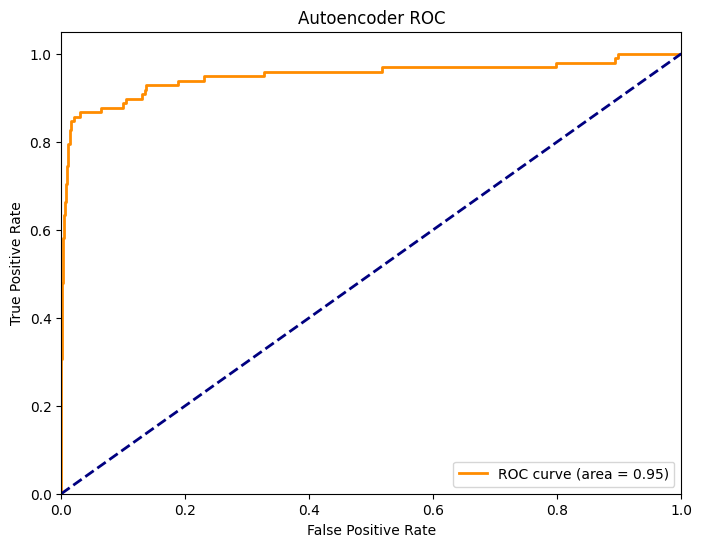

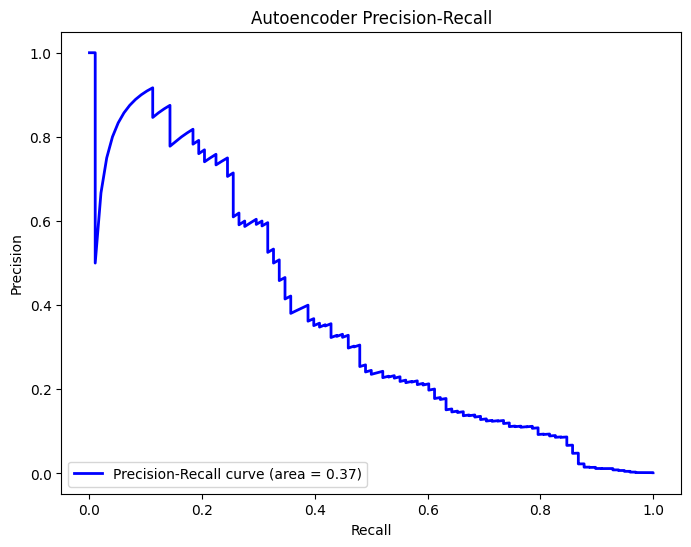

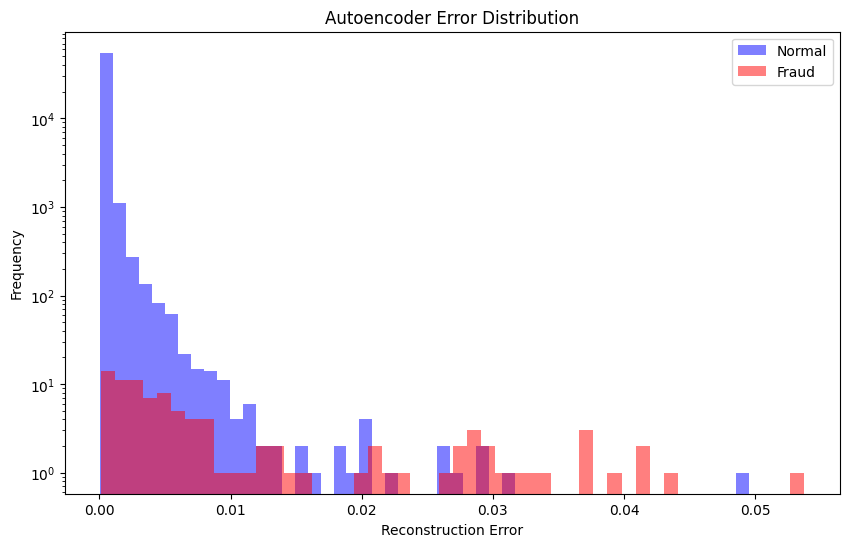

Training Variational Autoencoder
Epoch 1/50
891/891 [==============================] - 4s 3ms/step - loss: 19.8969 - val_loss: 18.7388
Epoch 2/50
891/891 [==============================] - 3s 4ms/step - loss: 18.3905 - val_loss: 18.1694
Epoch 3/50
891/891 [==============================] - 3s 3ms/step - loss: 18.1010 - val_loss: 18.0562
Epoch 4/50
891/891 [==============================] - 3s 3ms/step - loss: 18.0348 - val_loss: 18.0200
Epoch 5/50
891/891 [==============================] - 2s 3ms/step - loss: 18.0121 - val_loss: 18.0070
Epoch 6/50
891/891 [==============================] - 3s 3ms/step - loss: 18.0044 - val_loss: 18.0026
Epoch 7/50
891/891 [==============================] - 3s 4ms/step - loss: 18.0015 - val_loss: 18.0012
Epoch 8/50
891/891 [==============================] - 3s 3ms/step - loss: 18.0006 - val_loss: 18.0004
Epoch 9/50
891/891 [==============================] - 2s 3ms/step - loss: 18.0002 - val_loss: 18.0001
Epoch 10/50
891/891 [============================

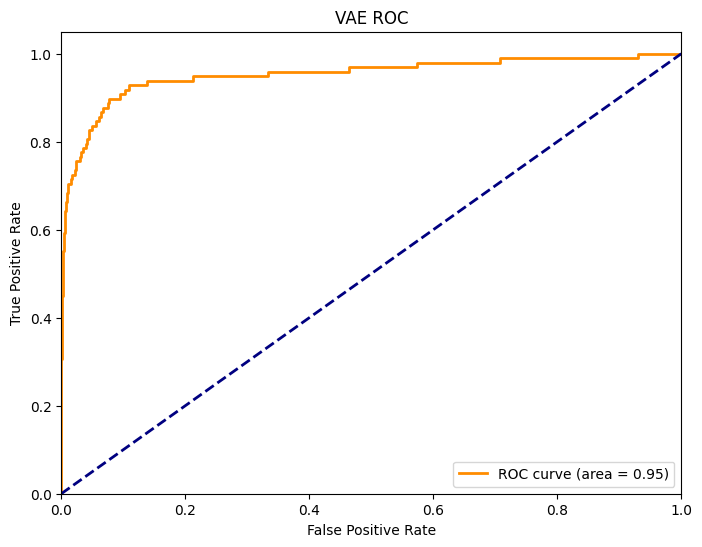

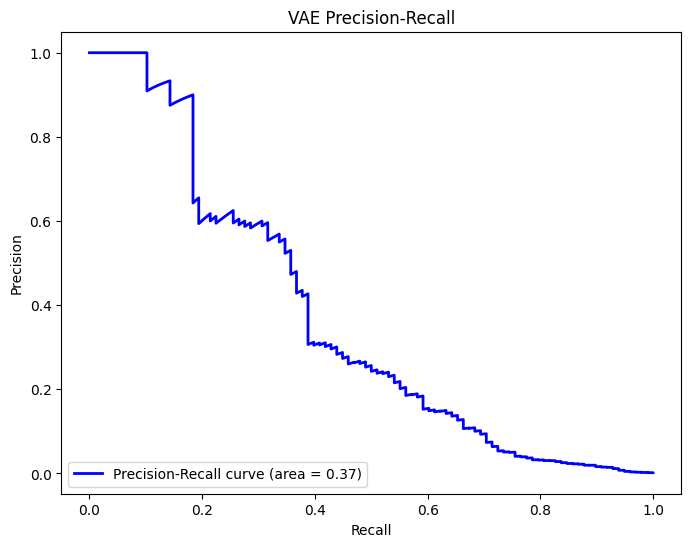

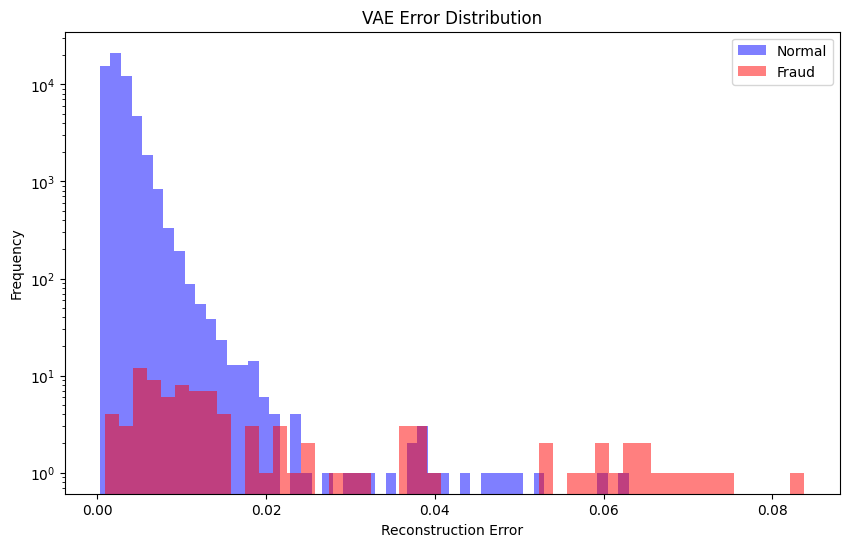

In [ ]:
def main():
    url = 'https://drive.google.com/uc?id=1mbioRY0d144mVqZPkYwYeJEgfS-8An1r'
    file_name = 'creditcard.csv'
    data = load_data(url, file_name)
    X_train, X_test, y_train, y_test = preprocess_data(data)

    # Train and evaluate Autoencoder
    print("Training Autoencoder")
    autoencoder = build_autoencoder(X_train.shape[1])
    autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, validation_data=(X_test, X_test))

    print("Evaluating Autoencoder")
    autoencoder_mse = get_reconstruction_error(autoencoder, X_test)
    threshold = np.quantile(autoencoder_mse, 0.95)
    ae_precision, ae_recall, ae_f1 = evaluate_model(y_test, autoencoder_mse, threshold)
    print("Autoencoder Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}".format(ae_precision, ae_recall, ae_f1))
    plot_roc_curve(y_test, autoencoder_mse, 'Autoencoder ROC')
    plot_precision_recall_curve(y_test, autoencoder_mse, 'Autoencoder Precision-Recall')
    plot_error_distribution(autoencoder_mse, y_test, 'Autoencoder Error Distribution')

    # Train and evaluate Variational Autoencoder
    print("Training Variational Autoencoder")
    vae = build_vae(X_train.shape[1])
    vae.fit(X_train, epochs=50, batch_size=256, validation_data=(X_test, None))

    print("Evaluating Variational Autoencoder")
    vae_mse = get_reconstruction_error(vae, X_test)
    threshold_vae = np.quantile(vae_mse, 0.95)
    vae_precision, vae_recall, vae_f1 = evaluate_model(y_test, vae_mse, threshold_vae)
    print("VAE Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}".format(vae_precision, vae_recall, vae_f1))
    plot_roc_curve(y_test, vae_mse, 'VAE ROC')
    plot_precision_recall_curve(y_test, vae_mse, 'VAE Precision-Recall')
    plot_error_distribution(vae_mse, y_test, 'VAE Error Distribution')

if __name__ == "__main__":
    main()


What These Visualizations Show:
ROC Curve: Illustrates the diagnostic ability of the model as its discrimination threshold is varied. The Area Under the Curve (AUC) gives a single measure of overall performance.
Precision-Recall Curve: Especially useful in situations with a significant class imbalance, as is common in fraud detection. The area under this curve provides a measure of the model’s ability to identify only the positive instances.
Error Distribution Histogram: Shows the distribution of reconstruction errors for both normal and fraudulent transactions. A good model should show distinct peaks for normal and fraudulent transactions, indicating a clear threshold can be established for anomaly detection.
These enhancements provide a more thorough evaluation of the model's performance, helping to visualize and understand how well the models are identifying anomalies in the dataset.

These additions provide deeper insights into the models' performance, allowing for a more nuanced understanding and potentially leading to improvements in fraud detection capabilities.


To further analyze the performance of both the autoencoder and the variational autoencoder (VAE) models, we can add additional metrics and visualizations. This extended analysis will include:

AUC-ROC Score: To quantify the overall ability of the models to discriminate between the classes.
Confusion Matrix: To visualize the counts of true positives, true negatives, false positives, and false negatives.
Threshold Analysis: To analyze how changes in the threshold affect the precision, recall, and F1 score

# **Confusion Matrix and Threshold Analysis**

Downloading...
From (original): https://drive.google.com/uc?id=1mbioRY0d144mVqZPkYwYeJEgfS-8An1r
From (redirected): https://drive.google.com/uc?id=1mbioRY0d144mVqZPkYwYeJEgfS-8An1r&confirm=t&uuid=65bc8208-06f4-4b19-935f-9170983c407a
To: /content/creditcard.csv
100%|██████████| 151M/151M [00:00<00:00, 192MB/s]


Training Autoencoder
Epoch 1/50
891/891 [==============================] - 2s 2ms/step - loss: 0.0046 - val_loss: 0.0022
Epoch 2/50
891/891 [==============================] - 3s 3ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 3/50
891/891 [==============================] - 2s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 4/50
891/891 [==============================] - 2s 2ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 5/50
891/891 [==============================] - 2s 2ms/step - loss: 9.1216e-04 - val_loss: 8.4215e-04
Epoch 6/50
891/891 [==============================] - 4s 4ms/step - loss: 7.9424e-04 - val_loss: 7.6681e-04
Epoch 7/50
891/891 [==============================] - 3s 3ms/step - loss: 7.5032e-04 - val_loss: 7.4068e-04
Epoch 8/50
891/891 [==============================] - 3s 3ms/step - loss: 7.2755e-04 - val_loss: 7.1791e-04
Epoch 9/50
891/891 [==============================] - 2s 2ms/step - loss: 6.8124e-04 - val_loss: 6.1356e-04
Epoch 10/50
891/891 [==================

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


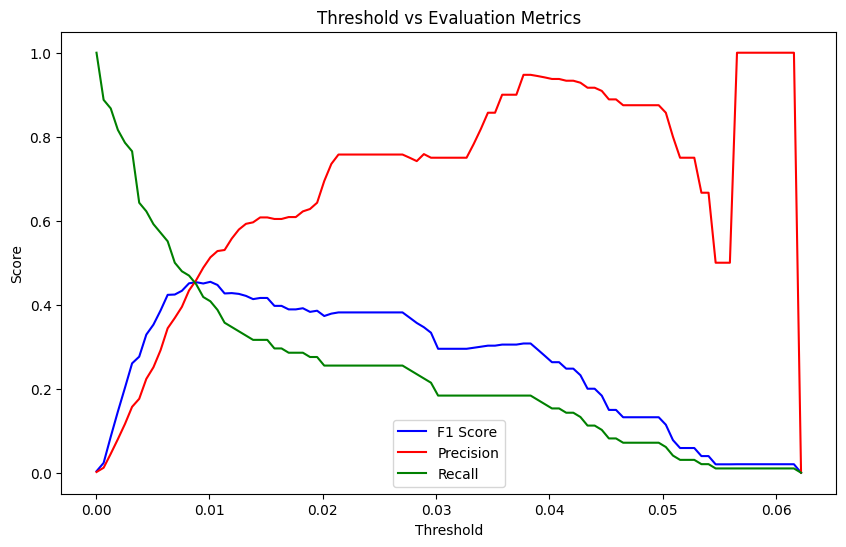

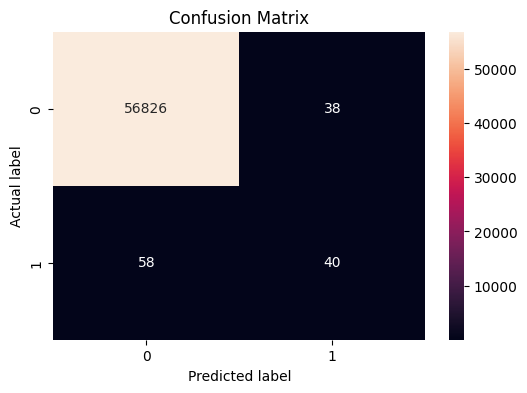

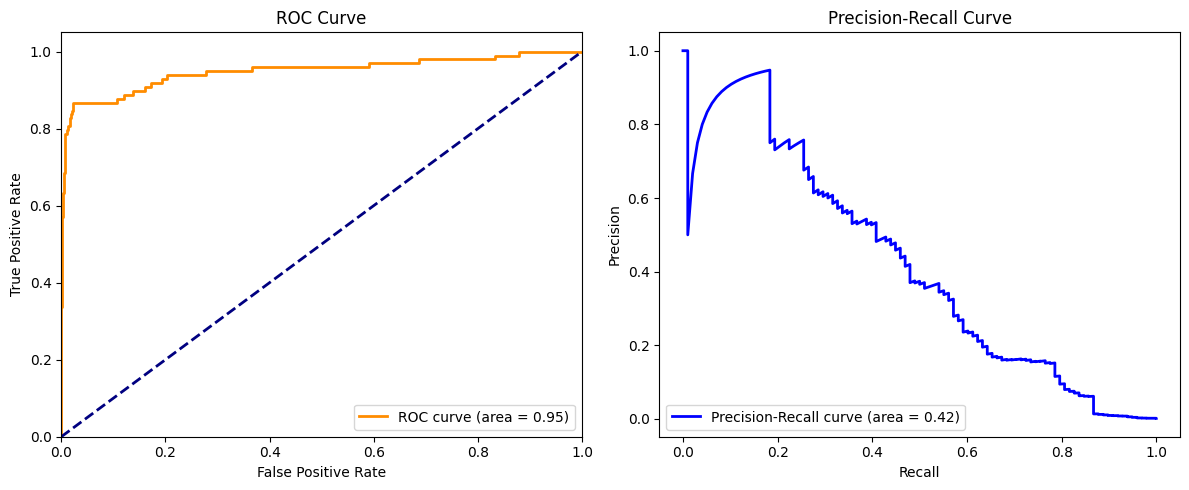

Training Variational Autoencoder
Epoch 1/50
891/891 [==============================] - 5s 3ms/step - loss: 19.7990 - val_loss: 18.7558
Epoch 2/50
891/891 [==============================] - 3s 3ms/step - loss: 18.4170 - val_loss: 18.1830
Epoch 3/50
891/891 [==============================] - 2s 3ms/step - loss: 18.1067 - val_loss: 18.0585
Epoch 4/50
891/891 [==============================] - 3s 3ms/step - loss: 18.0358 - val_loss: 18.0199
Epoch 5/50
891/891 [==============================] - 4s 5ms/step - loss: 18.0117 - val_loss: 18.0063
Epoch 6/50
891/891 [==============================] - 3s 3ms/step - loss: 18.0034 - val_loss: 18.0018
Epoch 7/50
891/891 [==============================] - 3s 3ms/step - loss: 18.0011 - val_loss: 18.0005
Epoch 8/50
891/891 [==============================] - 2s 3ms/step - loss: 18.0001 - val_loss: 17.9999
Epoch 9/50
891/891 [==============================] - 4s 5ms/step - loss: 17.9997 - val_loss: 17.9997
Epoch 10/50
891/891 [============================

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


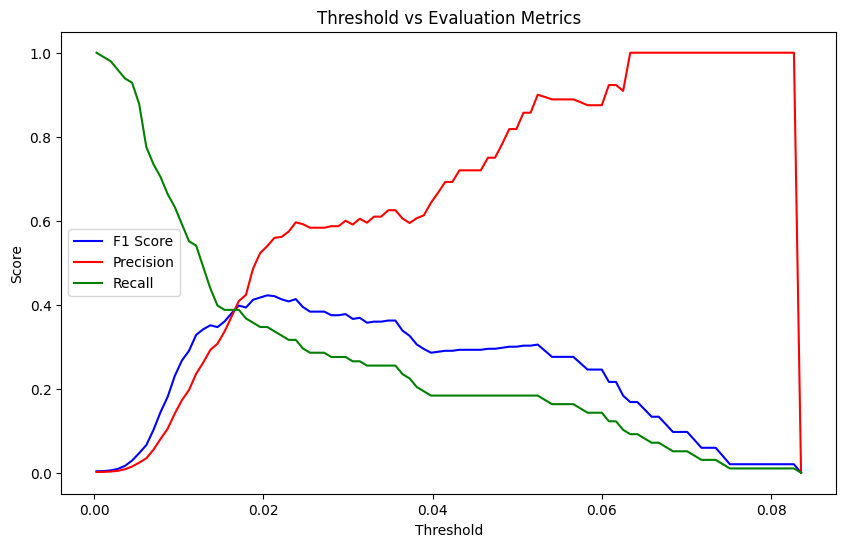

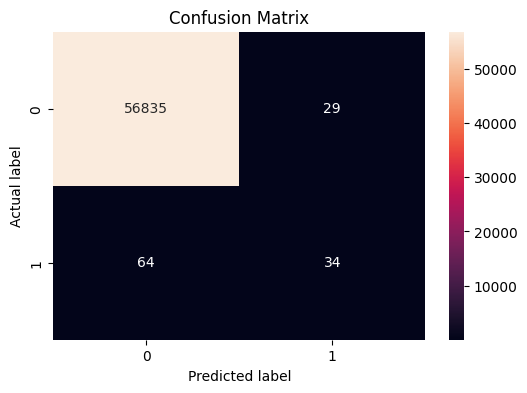

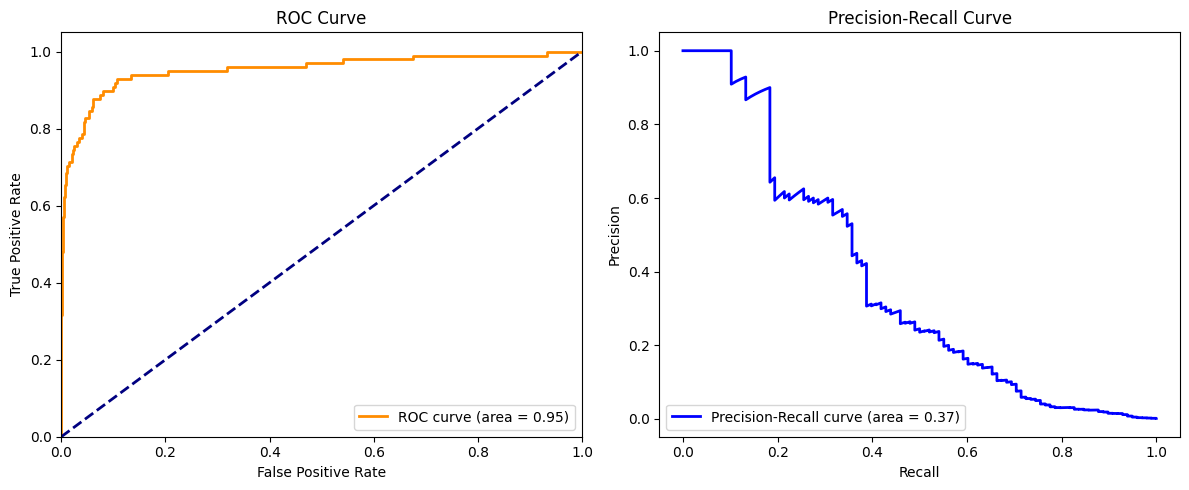

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import gdown
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_curve, roc_auc_score, f1_score, precision_score, recall_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras import backend as K

# Download and load the dataset from Google Drive
def load_data(url, file_name):
    gdown.download(url, file_name, quiet=False)
    return pd.read_csv(file_name)

# Preprocessing the dataset
def preprocess_data(data):
    data['Time'] = np.log(data['Time'] + 1)
    data['Amount'] = np.log(data['Amount'] + 1)
    scaler = MinMaxScaler()
    X = scaler.fit_transform(data.drop('Class', axis=1))
    y = data['Class']
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Building a simple autoencoder
def build_autoencoder(input_dim, encoding_dim=14):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

# Sampling function for VAE
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Building a variational autoencoder (VAE)
def build_vae(input_dim, encoding_dim=14):
    input_layer = Input(shape=(input_dim,))
    z_mean = Dense(encoding_dim)(input_layer)
    z_log_var = Dense(encoding_dim)(input_layer)
    z = Lambda(sampling, output_shape=(encoding_dim,))([z_mean, z_log_var])
    decoded = Dense(input_dim, activation='sigmoid')(z)

    encoder = Model(input_layer, [z_mean, z_log_var, z])
    vae = Model(input_layer, decoded)

    reconstruction_loss = tf.keras.losses.binary_crossentropy(input_layer, decoded) * input_dim
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1) * -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    return vae

# Function to compute reconstruction error
def get_reconstruction_error(model, X_test):
    predictions = model.predict(X_test)
    mse = np.mean(np.power(X_test - predictions, 2), axis=1)
    return mse

# Function to plot ROC and Precision-Recall Curves
def plot_metrics(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.show()

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(title)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

# Threshold analysis to find the best threshold
def threshold_analysis(errors, y_true):
    thresholds = np.linspace(min(errors), max(errors), 100)
    f1_scores = []
    precision_scores = []
    recall_scores = []
    for thresh in thresholds:
        y_pred = errors > thresh
        f1 = f1_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1_scores.append(f1)
        precision_scores.append(precision)
        recall_scores.append(recall)

    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores, label='F1 Score', color='blue')
    plt.plot(thresholds, precision_scores, label='Precision', color='red')
    plt.plot(thresholds, recall_scores, label='Recall', color='green')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Threshold vs Evaluation Metrics')
    plt.legend()
    plt.show()

    return optimal_threshold

# Main function to run the setup
def main():
    url = 'https://drive.google.com/uc?id=1mbioRY0d144mVqZPkYwYeJEgfS-8An1r'
    file_name = 'creditcard.csv'
    data = load_data(url, file_name)
    X_train, X_test, y_train, y_test = preprocess_data(data)

    print("Training Autoencoder")
    autoencoder = build_autoencoder(X_train.shape[1])
    autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, validation_data=(X_test, X_test))

    print("Evaluating Autoencoder")
    autoencoder_mse = get_reconstruction_error(autoencoder, X_test)
    optimal_threshold_ae = threshold_analysis(autoencoder_mse, y_test)
    y_pred_ae = autoencoder_mse > optimal_threshold_ae
    plot_confusion_matrix(y_test, y_pred_ae)
    plot_metrics(y_test, autoencoder_mse)

    print("Training Variational Autoencoder")
    vae = build_vae(X_train.shape[1])
    vae.fit(X_train, epochs=50, batch_size=256, validation_data=(X_test, None))

    print("Evaluating Variational Autoencoder")
    vae_mse = get_reconstruction_error(vae, X_test)
    optimal_threshold_vae = threshold_analysis(vae_mse, y_test)
    y_pred_vae = vae_mse > optimal_threshold_vae
    plot_confusion_matrix(y_test, y_pred_vae)
    plot_metrics(y_test, vae_mse)

if __name__ == "__main__":
    main()


Using above code we tackle fraud detection using machine learning models, specifically focusing on autoencoders and variational autoencoders (VAEs). Here's a brief summary of what the script accomplishes:

Data Handling: Downloads a dataset from a Google Drive link, applies logarithmic transformations to certain features to manage skewness, and scales all features to a range between 0 and 1. It then splits the data into training and testing sets.
Model Construction: Builds two types of models:
Autoencoder: A simple neural network model that learns to compress and then reconstruct the input data.
Variational Autoencoder (VAE): A more complex model that, in addition to reconstruction, learns the distribution of the input data, using a sampling method to generate new data points.
Model Training: Both models are trained on the training data, where they learn to minimize the difference between the original data and their reconstructions.
Evaluation and Visualization:
Reconstruction Error: Computes how well the models can reconstruct the test data, using the mean squared error between the original and reconstructed data.
ROC and Precision-Recall Curves: Provides visual insights into the models' performance at various thresholds, helpful for evaluating models on imbalanced datasets like fraud detection.
Confusion Matrix: Visualizes the classification accuracy, showing the number of true positives, false positives, true negatives, and false negatives.
Threshold Analysis: Investigates how different thresholds affect the models' precision, recall, and F1 scores, determining the optimal threshold for classifying a transaction as fraudulent or normal.
The script is structured to be run in an environment that supports TensorFlow, such as Google Colab, and requires internet access for downloading the dataset. It's designed to provide a thorough analysis of the model's capabilities in detecting fraudulent transactions, making it a valuable tool for anyone working in data security or financial analytics.

Downloading...
From (original): https://drive.google.com/uc?id=1mbioRY0d144mVqZPkYwYeJEgfS-8An1r
From (redirected): https://drive.google.com/uc?id=1mbioRY0d144mVqZPkYwYeJEgfS-8An1r&confirm=t&uuid=090b8a4e-13a6-4c78-87f7-c959f37b8df3
To: /content/creditcard.csv
100%|██████████| 151M/151M [00:01<00:00, 131MB/s]


Epoch 1/50
891/891 [==============================] - 4s 4ms/step - loss: 0.0380 - val_loss: 0.0111
Epoch 2/50
891/891 [==============================] - 3s 3ms/step - loss: 0.0075 - val_loss: 0.0053
Epoch 3/50
891/891 [==============================] - 2s 3ms/step - loss: 0.0044 - val_loss: 0.0038
Epoch 4/50
891/891 [==============================] - 2s 3ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 5/50
891/891 [==============================] - 2s 3ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 6/50
891/891 [==============================] - 4s 4ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 7/50
891/891 [==============================] - 3s 3ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 8/50
891/891 [==============================] - 2s 3ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 9/50
891/891 [==============================] - 2s 3ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 10/50
891/891 [==============================] - 3s 3ms/step - loss: 0.0027 - val_loss: 0.0027

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


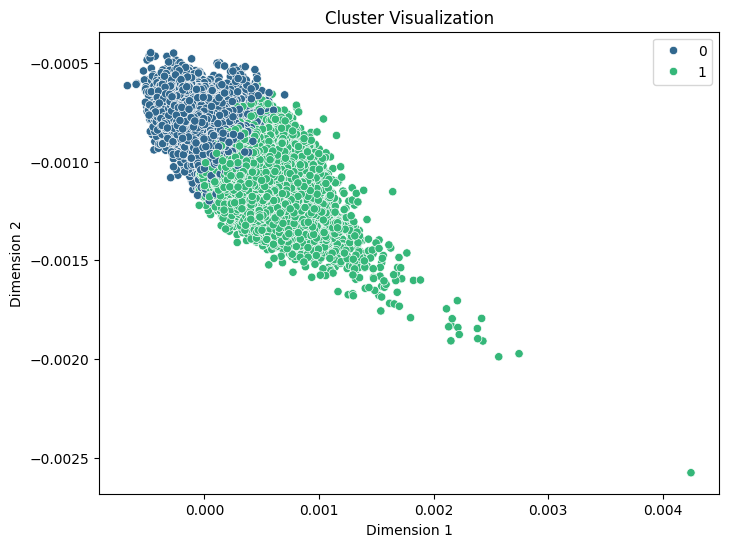

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import gdown

# Function to download and load data
def load_data(url, file_path):
    gdown.download(url, file_path, quiet=False)
    data = pd.read_csv(file_path)
    return data

# Function to preprocess data
def preprocess_data(data):
    data['Time'] = np.log(data['Time'] + 1)
    data['Amount'] = np.log(data['Amount'] + 1)
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(data.drop('Class', axis=1))
    return train_test_split(scaled_features, data['Class'], test_size=0.2, random_state=42)

# Building the Variational Autoencoder (VAE)
def vae_model(input_dim, encoding_dim=14):
    input_layer = Input(shape=(input_dim,))
    z_mean = Dense(encoding_dim)(input_layer)
    z_log_var = Dense(encoding_dim)(input_layer)

    # Reparameterization trick
    z = Lambda(lambda x: x[0] + K.exp(x[1] / 2) * K.random_normal(shape=(tf.shape(x[0])[0], encoding_dim)))(
        [z_mean, z_log_var])

    # Decoder part
    decoded = Dense(input_dim, activation='sigmoid')(z)

    # VAE model setup
    vae = Model(input_layer, decoded)
    reconstruction_loss = tf.reduce_mean(tf.square(input_layer - decoded))
    kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    vae.add_loss(reconstruction_loss + kl_loss)
    vae.compile(optimizer='adam')
    return vae, Model(input_layer, z_mean)

# Function to visualize 2D clusters
def plot_clusters(data, cluster_labels):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=cluster_labels, palette='viridis')
    plt.title('Cluster Visualization')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

# Main function to execute the processes
def main():
    url = 'https://drive.google.com/uc?id=1mbioRY0d144mVqZPkYwYeJEgfS-8An1r'
    file_path = 'creditcard.csv'
    data = load_data(url, file_path)
    X_train, X_test, y_train, y_test = preprocess_data(data)

    # Train Variational Autoencoder
    vae, encoder_vae = vae_model(X_train.shape[1])
    vae.fit(X_train, epochs=50, batch_size=256, validation_data=(X_test, None))

    # Encoding data
    encoded_data = encoder_vae.predict(X_train)
    kmeans = KMeans(n_clusters=2, random_state=42)
    clusters = kmeans.fit_predict(encoded_data)

    # Plotting the encoded data and clusters
    plot_clusters(encoded_data, clusters)

if __name__ == "__main__":
    main()


The script not only automates the process of training a VAE on transaction data but also visually and quantitatively analyzes the outcomes to detect patterns that could correspond to fraud. The visualization of clusters in the latent space is particularly useful for understanding the model’s effectiveness at identifying underlying structures in the data that might correspond to fraudulent activities.

This setup provides a comprehensive approach to using unsupervised learning for anomaly detection in financial transactions, making it a valuable tool for data scientists working in finance and security.

Downloading...
From (original): https://drive.google.com/uc?id=1mbioRY0d144mVqZPkYwYeJEgfS-8An1r
From (redirected): https://drive.google.com/uc?id=1mbioRY0d144mVqZPkYwYeJEgfS-8An1r&confirm=t&uuid=48267562-d8a3-405e-89e4-0080232a089b
To: /content/creditcard.csv
100%|██████████| 151M/151M [00:01<00:00, 144MB/s]


Epoch 1/50
889/889 [==============================] - 3s 2ms/step - loss: 0.0049 - val_loss: 0.0016
Epoch 2/50
889/889 [==============================] - 2s 2ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 3/50
889/889 [==============================] - 2s 2ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 4/50
889/889 [==============================] - 3s 3ms/step - loss: 9.5028e-04 - val_loss: 8.4333e-04
Epoch 5/50
889/889 [==============================] - 2s 3ms/step - loss: 6.7346e-04 - val_loss: 5.8615e-04
Epoch 6/50
889/889 [==============================] - 2s 2ms/step - loss: 5.2607e-04 - val_loss: 4.7104e-04
Epoch 7/50
889/889 [==============================] - 2s 2ms/step - loss: 4.4066e-04 - val_loss: 4.1717e-04
Epoch 8/50
889/889 [==============================] - 2s 2ms/step - loss: 4.0825e-04 - val_loss: 3.9941e-04
Epoch 9/50
889/889 [==============================] - 2s 2ms/step - loss: 3.9692e-04 - val_loss: 3.9257e-04
Epoch 10/50
889/889 [==============================]

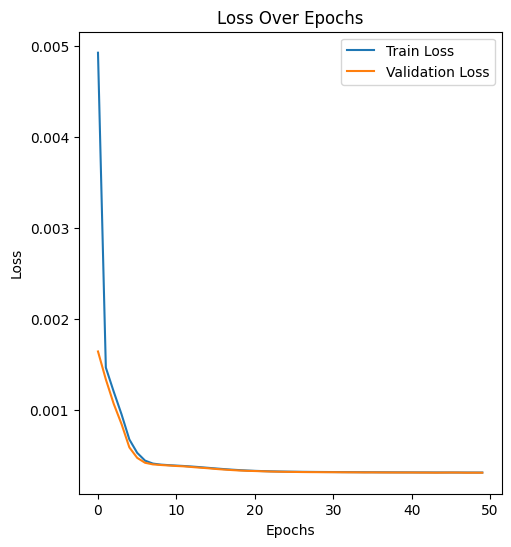

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import gdown

# Function to download, load, and preprocess the dataset
def load_and_preprocess_data(url, file_path):
    gdown.download(url, file_path, quiet=False)
    data = pd.read_csv(file_path)
    # Normalize and log transform Time and Amount
    data['Time'] = np.log(data['Time'] + 1)  # Adding 1 to avoid log(0)
    data['Amount'] = np.log(data['Amount'] + 1)
    scaler = MinMaxScaler()
    data.iloc[:, :-1] = scaler.fit_transform(data.iloc[:, :-1])
    return data

# Build the autoencoder model
def build_autoencoder(input_dim, encoding_dim=14):
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(encoding_dim, activation='relu')(input_layer)
    decoder = Dense(input_dim, activation='sigmoid')(encoder)
    autoencoder = Model(input_layer, decoder)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return autoencoder

# Function to train the autoencoder
def train_autoencoder(autoencoder, data, epochs=50, batch_size=256):
    X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)
    history = autoencoder.fit(X_train, X_train,
                              epochs=epochs,
                              batch_size=batch_size,
                              shuffle=True,
                              validation_data=(X_test, X_test),
                              verbose=1)
    return history, X_test

# Evaluate the model
def evaluate_model(autoencoder, X_test, threshold_factor=1.5):
    reconstructions = autoencoder.predict(X_test)
    reconstruction_errors = np.mean(np.abs(reconstructions - X_test), axis=1)
    threshold = np.mean(reconstruction_errors) + threshold_factor * np.std(reconstruction_errors)
    print("Calculated threshold: ", threshold)
    return threshold

# Plotting function for training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Main function to execute the processes
def main():
    url = 'https://drive.google.com/uc?id=1mbioRY0d144mVqZPkYwYeJEgfS-8An1r'
    file_path = 'creditcard.csv'
    data = load_and_preprocess_data(url, file_path)

    # Train on non-fraudulent transactions only
    normal_data = data[data['Class'] == 0].drop(columns=['Class'])

    # Build and train the autoencoder
    autoencoder = build_autoencoder(input_dim=normal_data.shape[1], encoding_dim=14)
    history, X_test = train_autoencoder(autoencoder, normal_data)

    # Evaluate the model
    threshold = evaluate_model(autoencoder, X_test)

    # Optionally plot training history
    plot_training_history(history)

if __name__ == "__main__":
    main()


The provided Python script effectively addresses the project question of designing an autoencoder to detect fraudulent transactions within a dataset of credit card transactions. Here's a brief summary of how the code works and fulfills the project requirements:

Objective
The primary goal is to develop an autoencoder that learns to compress and decompress non-fraudulent credit card transactions, aiming to capture the typical patterns of normal transactions. By training solely on non-fraudulent data, the model is expected to have higher reconstruction errors for anomalies (fraudulent transactions), which can then be identified based on these errors.

Key Steps in the Code
Data Handling
Download and Load: The script uses gdown to download the dataset directly from a Google Drive link and loads it into a Pandas DataFrame.
Preprocessing: Applies logarithmic transformations to the 'Time' and 'Amount' columns to manage data scale and variability. It also normalizes all other features using MinMaxScaler, preparing the dataset for effective neural network training.
Autoencoder Construction
Model Architecture: Sets up a simple autoencoder with a single hidden layer that serves as the encoder, reducing the dimensionality to a specified latent space (14 dimensions by default). The decoder part of the autoencoder aims to reconstruct the input data from this compressed representation.
Compilation: The model is compiled with the Adam optimizer and mean squared error (MSE) as the loss function, which is appropriate for a regression-like task such as reconstruction.
Training
The autoencoder is trained exclusively on non-fraudulent transactions. This selective training helps the model specialize in reconstructing typical, normal transaction patterns, making it sensitive to deviations represented by fraudulent transactions.
Evaluation
Reconstruction Error: Post-training, the script calculates the reconstruction error on the test data. It also establishes a threshold for anomaly detection, set as the mean plus a factor (1.5 times) of the standard deviation of these errors.
Threshold for Anomaly Detection: Transactions with reconstruction errors exceeding this threshold are candidates for further investigation as potential frauds.
Visualization
Provides visual feedback on the training process by plotting the training and validation losses over epochs. This helps in monitoring the model's learning progress and ensuring it is fitting well without overfitting or underfitting.
Addressing the Project Question
The script aligns with the project's requirements by:

Designing an appropriate autoencoder architecture: The choice of a simple, single-layer encoder and decoder is justified by the need for a model complex enough to capture essential data characteristics but not so complex that it overfits the normal transaction patterns.
Optimizing for a specific task: By training the model solely on normal transactions, it becomes specifically tuned to identify non-normal patterns, effectively addressing the anomaly detection task.
Utilizing reconstruction error for anomaly detection: This approach is standard in unsupervised anomaly detection tasks where labels are scarce or imbalanced, as is typical in fraud detection scenarios.
Overall, the script sets up a robust methodology for learning normal transaction patterns and using deviations from these patterns to flag potential fraudulent activities, effectively addressing the project's objectives with a clear, structured approach.






